# Segmentation on Indian traffic

## Introduction  

This notebook explores the segmentation of **Indian traffic images** using advanced deep learning techniques. Segmentation tasks in traffic scenarios are crucial for a variety of applications, such as autonomous driving, traffic monitoring, and urban planning. The goal of this project was to preprocess the dataset, extract meaningful features, and apply segmentation models to generate accurate annotations for Indian traffic scenes.

### Objectives:  
1. **Preprocessing the Dataset**:  
   - Parse and understand the dataset structure, including associated JSON files containing annotations.  
   - Extract polygons and unique labels from the dataset to prepare for segmentation tasks.  
   - Convert annotation data into image segmentations for visualization and training.  

2. **Application of Segmentation Models**:  
   - Train and evaluate the **UNet model**, a popular architecture for image segmentation, using a customized loss function like Dice Loss.  
   - Implement **CANet**, a specialized network for segmentation, to improve results further.  

3. **Observations and Insights**:  
   - Analyze the results of the models to evaluate performance and identify areas for improvement.  

### Key Takeaways:  
- The preprocessing pipeline emphasizes the importance of label extraction and conversion of polygonal annotations into usable image masks.  
- The implementation of **Dice Loss** ensures robust model optimization for handling imbalanced segmentation data.  
- By comparing UNet and CANet, we derive insights into the efficacy of different architectures for real-world segmentation tasks.  

### Importance of This Project:  
Indian traffic scenes often exhibit unique challenges, including high density, diverse object classes, and occlusions. This project demonstrates the application of state-of-the-art techniques to handle these challenges effectively, providing a robust framework for similar segmentation tasks in other complex environments.  

---

## Useful Tips:

- Use `interpolation=cv2.INTER_NEAREST` when resizing images to ensure the number of classes in the segmented output remains unaffected.  
- Keep the input images in square shapes like $256 \times 256$ or $512 \times 512$ for consistency and better performance.  
- Be cautious when converting the output segmentation images from `(W, H)` to `(W, H, Classes)` to maintain dimensional integrity.  
- For CANet, use segmentation model-specific losses and metrics to achieve better accuracy and meaningful results.  
- This project was an excellent opportunity to work on computer vision problems, including image preprocessing, building complex architectures, and implementing research papers. It helped in gaining confidence in tackling industry-relevant challenges.  
- Use TensorBoard logs to monitor model training and evaluate performance over epochs.  
- Employ callbacks like early stopping and learning rate schedulers to optimize model training.  



# Segmentation of Indian Traffic

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install interfaces
!pip install -U segmentation-models
!pip install keras==2.3.1
!pip install tensorflow==2.2.0


In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
pd.set_option('display.max_colwidth', 150)
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from skimage.io import imread, imshow
from skimage.transform import resize
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
# tf.enable_eager_execution()
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
# from hilbert import hilbertCurve
import imgaug.augmenters as iaa
import numpy as np
import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Input,Conv2D,MaxPool2D,Activation,Dropout,Flatten, BatchNormalization, ReLU, Reshape
from tensorflow.keras.models import Model
import random as rn
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Flatten

In [ ]:
from zipfile import ZipFile

# specifying the zip file name
file_name = "/content/drive/My Drive/Segmentation assignment/data.zip"

# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    zip.extractall('/content/sample_data')


In [ ]:
del zip

<pre>

1. Inside the data there are two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
def return_file_names_df(root_dir):
    # write the code that will create a dataframe with two columns ['images', 'json']
    # the column 'image' will have path to images
    # the column 'json' will have path to json files
    data_df=pd.DataFrame(columns=['image','json'])

    data=os.listdir(root_dir+'/data/')
    images=os.listdir(root_dir+'/data/images/')
    masks=os.listdir(root_dir+'/data/mask/')

    im=[]
    ma=[]
    for i in images :

        folder= os.listdir(root_dir+'/data/images/'+i+'/')
        for j in folder:
            im.append('/data/images/'+i+'/'+os.path.basename(j))

    for i in masks :
        #print('mask folder no. : ',i)
        folder= os.listdir(root_dir+'/data/mask/'+i+'/')
        for j in folder:
            ma.append('/data/mask/'+i+'/'+os.path.basename(j))


    data_df['image']=im
    data_df['json']=ma
    return data_df

In [ ]:
data_df = return_file_names_df(root_dir)
data_df.head()

image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  
0  data/mask/201/frame0029_gtFine_polygons.json  
1  data/mask/201/frame0299_gtFine_polygons.json  
2  data/mask/201/frame0779_gtFine_polygons.json  
3  data/mask/201/frame1019_gtFine_polygons.json  
4  data/mask/201/frame1469_gtFine_polygons.json

In [ ]:
root_dir='/content/sample_data'
os.chdir(root_dir)
data_df = return_file_names_df(root_dir)
data_df.head()

> If we observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:

def grader_1(data_df):
    for i in data_df.values:
        #print(i[0])
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            #print(path.isfile(i[0]))
            #print(path.isfile(i[1]))
            return False
    return True

In [ ]:
grader_1(data_df)

True

In [ ]:
data_df.shape

(4008, 2)

## 2. Structure of sample Json file

<img src='https://i.imgur.com/EfR5KmI.png' width="" height="">

* Each File will have 3 attributes
    * imgHeight: which tells the height of the image
    * imgWidth: which tells the width of the image
    * objects: it is a list of objects, each object will have multiple attributes,
        * label: the type of the object
        * polygon: a list of two element lists, representing the coordinates of the polygon

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    # for each file in the column json
    #       read and store all the objects present in that file
    # compute the unique objects and retrun them
    # if open any json file using any editor you will get better sense of it

    label=[]

    for i in tqdm(data_df['json']):
        f=open(i,'r')
        d=json.load(f)
        for j in d['objects']:
            label.append(j['label'])
        f.close()
    unique_labels=(set(label))
    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


In [ ]:
len(set(label_clr.values()))

21

<pre>
* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map
* Before you pass it to the models, you might need to divide the image array /10.
</pre>

## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    # this function will take a file name as argument
    f=open(file,'r')
    d=json.load(f)

    # it will process all the objects in that file and returns
    # label: a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
    # len(label) == number of objects in the image

    # vertexlist: it should be list of list of vertices in tuple formate
    # ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
    #     [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
    #      .....
    #     [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
    # len(vertexlist) == number of objects in the image

    label=[]
    vertexlist=[]
    for j in (d['objects']):
        label.append(j['label'])
        vertexlist.append(j['polygon'])

    for i in vertexlist:
        for j in range(len(i)):
            i[j]=tuple(i[j])

    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    # width of the image
    w=d['imgWidth']
    # height of the image
    h=d['imgHeight']
    return w, h, label, vertexlist

In [ ]:
def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

grader_3('data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
side=8

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

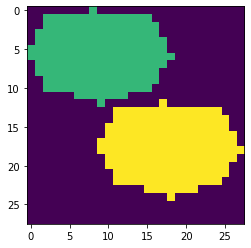

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
def compute_masks(data_df):
    # after you have computed the vertexlist plot that polygone in image like this
    output=[]
    parent_dir="/content/sample_data/data/output"
    try: os.mkdir(parent_dir)
    except: pass
    for i in tqdm(range(len(data_df))):
        file=data_df['json'][i]
        w, h, labels, vertexlist = get_poly(file)
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
        img = Image.new("RGB", (w, h))
        img1 = ImageDraw.Draw(img)
        for j in range(len(labels)):
            try:
                img1.polygon(vertexlist[j], fill = label_clr[labels[j]])
            except:
                pass
        img=np.array(img)
        im = Image.fromarray(img[:,:,0])
        dir=file[10:13]
        path = os.path.join(parent_dir, dir)
        try:
            os.mkdir(path)
        except:
            pass

        im.save(path+file[13:-5]+".png")
        #output.append("data/output/"+file[10:-5]+".png")
    # after drawing all the polygons that we collected from json file,
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    #data_df['mask']=output
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths

    return data_df

In [ ]:
data_df = compute_masks(data_df)
data_df.head()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4008/4008 [04:16<00:00, 15.61it/s]


image  \
0  data/images/201/frame0029_leftImg8bit.jpg   
1  data/images/201/frame0299_leftImg8bit.jpg   
2  data/images/201/frame0779_leftImg8bit.jpg   
3  data/images/201/frame1019_leftImg8bit.jpg   
4  data/images/201/frame1469_leftImg8bit.jpg   

                                           json  \
0  data/mask/201/frame0029_gtFine_polygons.json   
1  data/mask/201/frame0299_gtFine_polygons.json   
2  data/mask/201/frame0779_gtFine_polygons.json   
3  data/mask/201/frame1019_gtFine_polygons.json   
4  data/mask/201/frame1469_gtFine_polygons.json   

                                            mask  
0  data/output/201/frame0029_gtFine_polygons.png  
1  data/output/201/frame0299_gtFine_polygons.png  
2  data/output/201/frame0779_gtFine_polygons.png  
3  data/output/201/frame1019_gtFine_polygons.png  
4  data/output/201/frame1469_gtFine_polygons.png

In [ ]:
#reading the saved dataframe.
data_df=pd.read_csv('/content/drive/My Drive/Segmentation assignment/preprocessed_data.csv')

In [ ]:
root_dir='/content/sample_data'
os.chdir(root_dir)
data_df_1 = compute_masks(data_df)
data_df_1.head()

image  ...                                          mask
0  data/images/201/frame0029_leftImg8bit.jpg  ...  data/ouput/201/frame0029_gtFine_polygons.png
1  data/images/201/frame0299_leftImg8bit.jpg  ...  data/ouput/201/frame0299_gtFine_polygons.png
2  data/images/201/frame0779_leftImg8bit.jpg  ...  data/ouput/201/frame0779_gtFine_polygons.png
3  data/images/201/frame1019_leftImg8bit.jpg  ...  data/ouput/201/frame1019_gtFine_polygons.png
4  data/images/201/frame1469_leftImg8bit.jpg  ...  data/ouput/201/frame1469_gtFine_polygons.png

[5 rows x 3 columns]

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


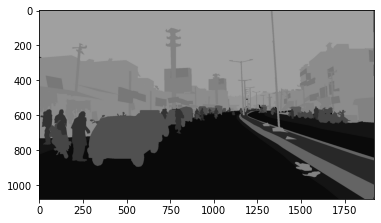

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


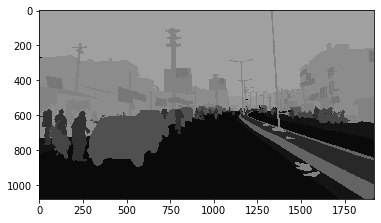

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

<pre>
* please check the paper: https://arxiv.org/abs/1505.04597

* <img src='https://i.imgur.com/rD4yP7J.jpg' width="500">

* As a part of this assignment we won't writingt this whole architecture, rather we will be doing transfer learning

* please check the library <a hreaf='https://github.com/qubvel/segmentation_models'>https://github.com/qubvel/segmentation_models</a>

* You can install it like this "pip install -U segmentation-models==0.2.1", even in google colab you can install the    same with "!pip install -U segmentation-models==0.2.1"

* Check the reference notebook in which we have solved one end to end case study of image forgery detection using same  unet

* The number of channels in the output will depend on the number of classes in your data, since we know that we are having 21 classes, the number of channels in the output will also be 21

* <strong>This is where we want you to explore, how do you featurize your created segmentation map note that the original map will be of (w, h, 1) and the output will be (w, h, 21) how will you calculate the loss</strong>, you can check the examples in segmentation github

* please use the loss function that is used in the refence notebooks

</pre>

### Task 2.1: Dice loss

<pre>
* Explain the Dice loss
* 1. Write the formualtion
* 2. Range of the loss function
* 3. Interpretation of loss function
* 4. Write your understanding of the loss function, how does it helps in segmentation
</pre>

Dice loss is based on Dice Coefficient:

- Dice= (2*TP)/(2*TP+FP+FP)
So, the loss can be defined as 1-Dice.

- Range= [0,1]

- Dice can be interpreted as intersection over intersection plus union which considers the loss both locally and globally.

- its basically the F1 score, which is finding a tradeoff b/w precision and recall. Unlike cross -entropy it doesn't give equal imp. to each pixel which is not correct as we have diff. classes in the image which creates imbalance in the representation.In Dice loss, we double counts the intersection part and thus it helps in segmentation.  

### Task 2.2: Training Unet


<pre>
* Split the data into 80:20.
* Train the UNET on the given dataset and plot the train and validation loss.
* As shown in the reference notebook plot 20 images from the test data along with its segmentation map, predicted map.
</pre>

In [ ]:
tf.keras.backend.clear_session
# here dir_path is the route directory where all the images and segmentation maps are there
file_names = []
for i in (data_df_1['image']):
    file_names.append(i.split('_')[0][12:])

file_names=np.array(file_names)

In [ ]:
X_train, X_test = train_test_split(file_names, test_size=0.20, random_state=65)

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

Segmentation Models: using `keras` framework.


Using TensorFlow backend.


In [ ]:
# loading the unet model and using the resnet 34 and initilized weights with imagenet weights
# "classes" :different types of classes in the dataset
model_unet = Unet(backbone_name='resnet34', encoder_weights='imagenet', classes=21, activation='softmax', input_shape=(256,256,3))

In [ ]:
model_unet.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
____________________________________________________________________________________________

In [ ]:
# import imgaug.augmenters as iaa
# For the assignment choose any 4 augumentation techniques
# check the imgaug documentations for more augmentations
aug2 = iaa.Fliplr(1)
aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))


In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

In [ ]:
def normalize_image(mask):
    mask = mask/255
    return mask

In [ ]:

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['road','drivable fallback','sidewalk','non-drivable fallback','person','animal','rider','motorcycle','autorickshaw',\
               'truck','curb','fence','billboard','pole','building''vegetation','sky','unlabeled','ego vehicle','ground','rectification border',\
               'train']

    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir,mask_dir, file_names,classes):

        self.ids = file_names
        # the paths of images
        self.images_fps   = [os.path.join(images_dir, image_id+'_leftImg8bit.jpg') for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [os.path.join(mask_dir, image_id+"_gtFine_polygons.png") for image_id in self.ids]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.w=256
        self.h=256

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image_mask = (mask[:,:])//10
        image_masks = [(image_mask == v) for v in self.class_values]
        #print(self.class_values)
        #print(image_masks)
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        #print(image_mask.shape)

        a = np.random.uniform()
        if a<0.25:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.5:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
        elif a<0.75:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        else:
            image = aug5.augment_image(image)
            image_mask = image_mask

        #p#rint(image_mask.shape)
        #print(image.shape)
        return image, image_mask

    def __len__(self):
        return len(self.ids)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

optim = tf.keras.optimizers.Adam(0.0001)

#focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
total_loss = sm.losses.cce_dice_loss
model_unet.compile(optim, total_loss, metrics=[iou_score])

In [ ]:
# Dataset for train images

CLASSES = ['road','drivable fallback','sidewalk','non-drivable fallback','person','animal','rider','motorcycle','autorickshaw',\
                'truck','curb','fence','billboard','pole','building''vegetation','sky','unlabeled','ego vehicle','ground','rectification border',\
                'train']

img_path='data/images/'
mask_path='data/output/'

train_dataset = Dataset(img_path,mask_path,X_train, classes=CLASSES)
test_dataset  = Dataset(img_path,mask_path,X_test, classes=CLASSES)


train_dataloader = Dataloder(train_dataset, batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=2, shuffle=True)
print(train_dataloader[0][0].shape)


(4, 256, 256, 3)


In [ ]:
history1 = model_unet.fit_generator(train_dataloader, steps_per_epoch=len(train_dataloader), epochs=30,
                              validation_data=test_dataloader)#,callbacks=callbacks)

Epoch 1/30
801/801 [==============================] - 450s 562ms/step - loss: 0.8745 - iou_score: 0.1458 - val_loss: 0.7623 - val_iou_score: 0.1990
Epoch 2/30
801/801 [==============================] - 442s 552ms/step - loss: 0.7244 - iou_score: 0.2548 - val_loss: 0.7517 - val_iou_score: 0.1016
Epoch 3/30
801/801 [==============================] - 437s 545ms/step - loss: 0.6432 - iou_score: 0.3314 - val_loss: 0.6384 - val_iou_score: 0.3000
Epoch 4/30
801/801 [==============================] - 442s 551ms/step - loss: 0.5995 - iou_score: 0.3632 - val_loss: 0.6421 - val_iou_score: 0.3158
Epoch 5/30
801/801 [==============================] - 440s 550ms/step - loss: 0.5749 - iou_score: 0.3878 - val_loss: 0.6419 - val_iou_score: 0.3357
Epoch 6/30
801/801 [==============================] - 444s 554ms/step - loss: 0.5534 - iou_score: 0.3231 - val_loss: 0.6118 - val_iou_score: 0.3436
Epoch 7/30
801/801 [==============================] - 444s 554ms/step - loss: 0.5415 - iou_score: 0.3931 - val_l

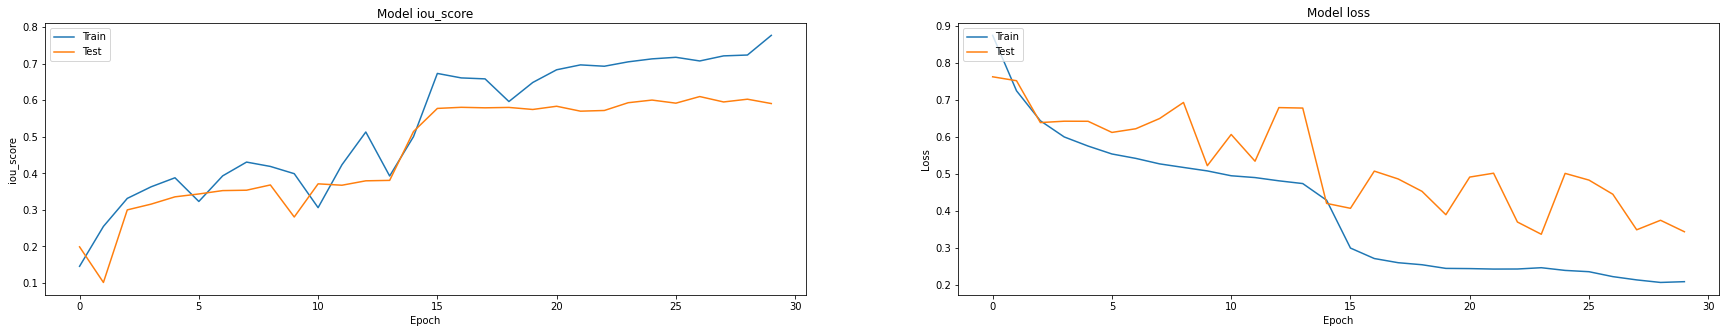

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history1.history['iou_score'])
plt.plot(history1.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

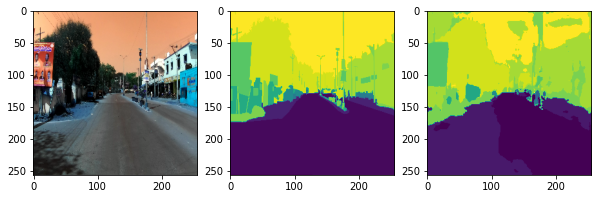

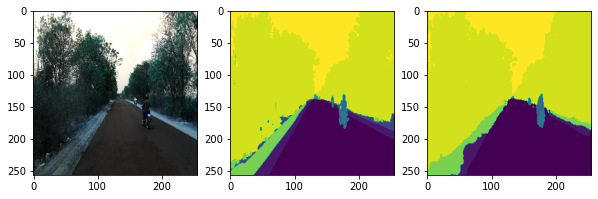

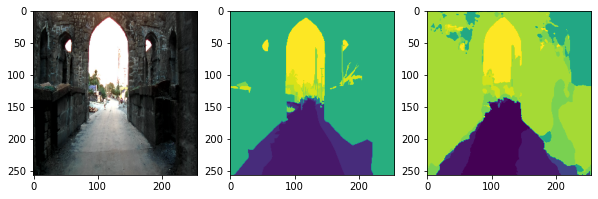

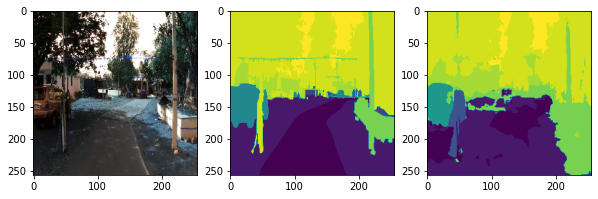

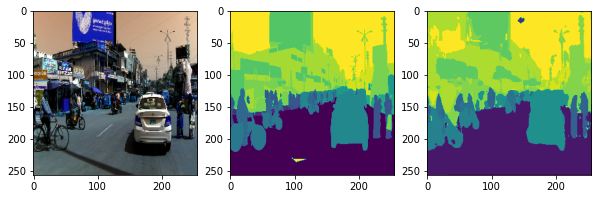

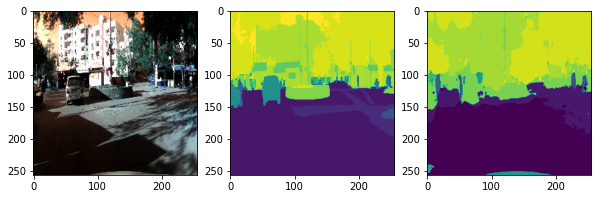

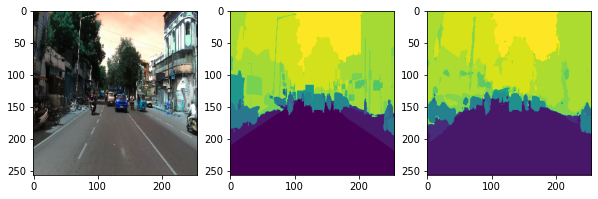

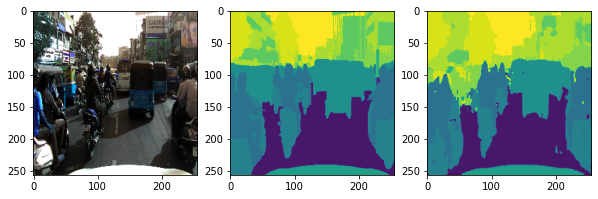

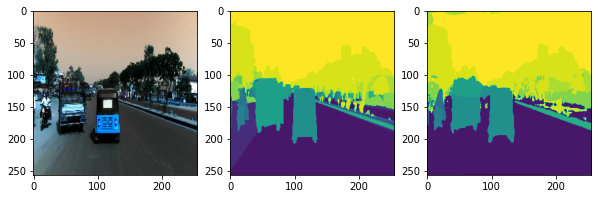

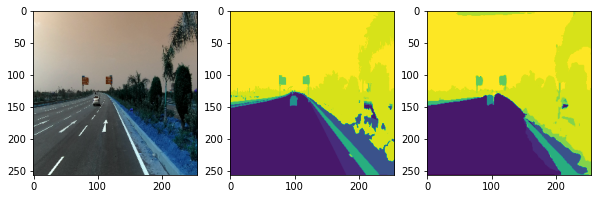

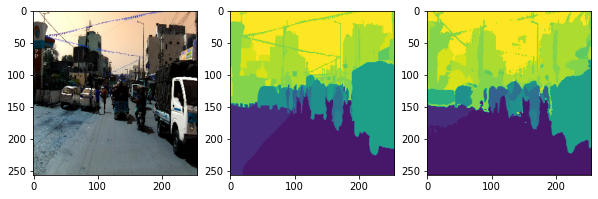

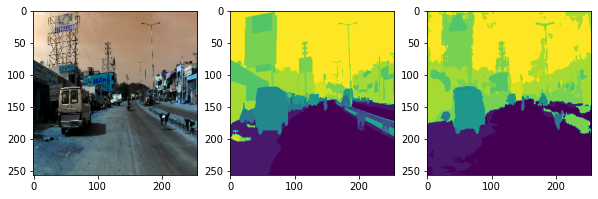

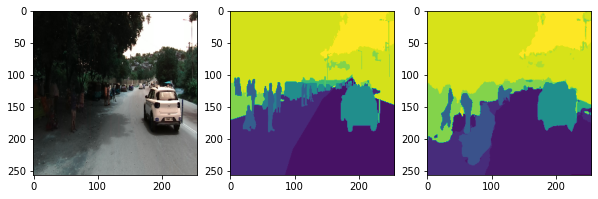

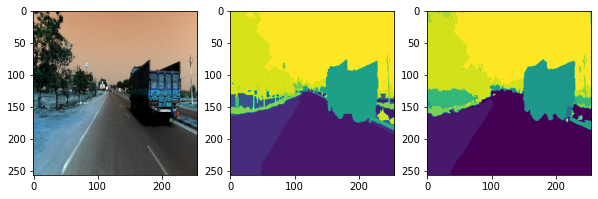

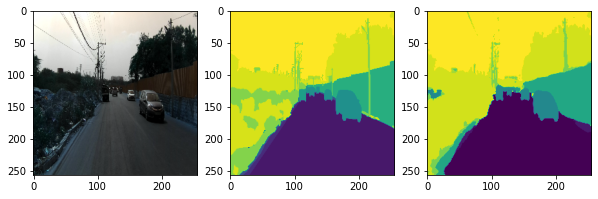

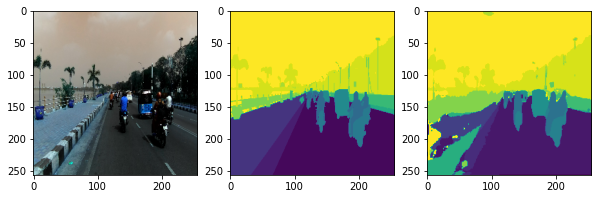

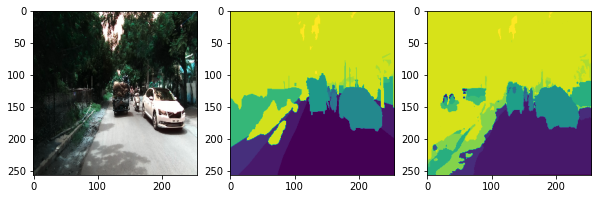

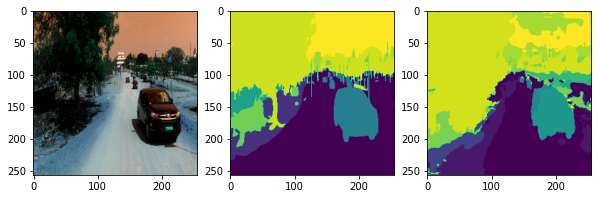

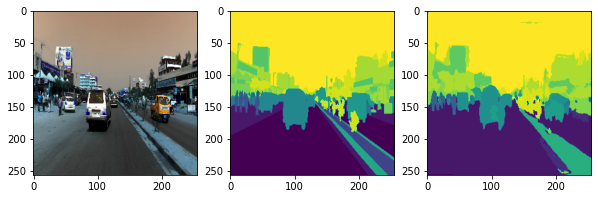

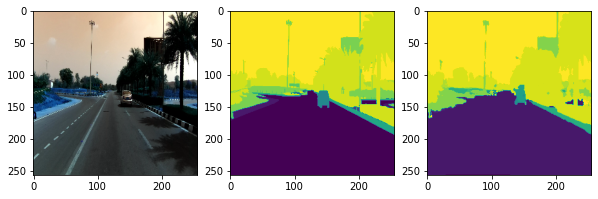

In [ ]:

for p, i in enumerate(X_test[0:20]):
    #original image
    image = cv2.imread(os.path.join(img_path, i+'_leftImg8bit.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256))

    #predicted segmentation map
    predicted  = model_unet.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted,axis=-1)

    #original segmentation map
    image_mask = cv2.imread(os.path.join(mask_path, i+'_gtFine_polygons.png'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))


    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)#, cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted[0])#, cmap='gray')
    plt.show()

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

* as a part of this assignment we will be implementing the architecture based on this paper https://arxiv.org/pdf/2002.12041.pdf
* We will be using the custom layers concept that we used in seq-seq assignment
* You can devide the whole architecture can be devided into two parts
    1. Encoder
    2. Decoder
    <img src='https://i.imgur.com/prH3Mno.png' width="600">
* Encoder:
    * The first step of the encoder is to create the channel maps [$C_1$, $C_2$, $C_3$, $C_4$]
    * $C_1$ width and heigths are 4x times less than the original image
    * $C_2$ width and heigths are 8x times less than the original image
    * $C_3$ width and heigths are 8x times less than the original image
    * $C_4$ width and heigths are 8x times less than the original image
    * <i>you can reduce the dimensions by using stride parameter</i>.
    * [$C_1$, $C_2$, $C_3$, $C_4$] are formed by applying a "conv block" followed by $k$ number of "identity block". i.e the $C_k$ feature map will single "conv block" followed by $k$ number of "identity blocks".
    <table>
    <tr><td><img src="https://i.imgur.com/R8Gdypo.png" width="300"></td>
        <td><img src="https://i.imgur.com/KNunjQK.png" width="250"></td></tr>
    </table>
    * <strong>The conv block and identity block of $C_1$</strong>: the number filters in the covolutional layers will be $[4,4,8]$ and the number of filters in the parallel conv layer will also be $8$.
    * <strong>The conv block and identity block of $C_2$</strong>: the number filters in the covolutional layers will be $[8,8,16]$ and the number of filters in the parallel conv layer will also be $16$.
    * <strong>The conv block and identity block of $C_3$</strong>: the number filters in the covolutional layers will be $[16,16,32]$ and the number of filters in the parallel conv layer will also be $32$.
    * <strong>The conv block and identity block of $C_4$</strong>: the number filters in the covolutional layers will be $[32,32,64]$ and the number of filters in the parallel conv layer will also be $64$.
    * Here $\oplus$ represents the elementwise sum
    <br>
    
    <font color="red">NOTE: these filters are of your choice, you can explore more options also</font>
    
    * Example: if your image is of size $(512, 512, 3)$
        * the output after $C_1$ will be $128*128*8$
        * the output after $C_2$ will be $64*64*16$
        * the output after $C_3$ will be $64*64*32$
        * the output after $C_4$ will be $64*64*64$

In [ ]:
class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, kernel=3,  filters=[4,4,8], stride=1,m=2,name='CB'):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel
        self.stride = stride
        self.m=m

        self.C1=Conv2D(self.F1,1 , padding='same')
        self.B1=BatchNormalization()
        self.A1=Activation('relu')
        self.C2=Conv2D(self.F2,self.kernel, padding='same')
        self.B2=BatchNormalization()
        self.A2=Activation('relu')
        self.C3=Conv2D(self.F3,1 , padding='same')
        self.B3=BatchNormalization()
        self.M1= MaxPooling2D(self.m, strides=self.stride)

        self.C4=Conv2D(self.F3,1, padding='same')
        self.B4=BatchNormalization()
        self.A3=Activation('relu')
        self.M2= MaxPooling2D(self.m, strides=self.stride)

        self.S= Add()

        self.A4=Activation('relu')

    def call(self, inputs):
        # write the architecutre that was mentioned above
        #print('Conv block i/p : ',inputs.shape)
        X=self.C1(inputs)
        X=self.B1(X)
        X=self.A1(X)
        X=self.C2(X)
        X=self.B2(X)
        X=self.A2(X)
        X=self.C3(X)
        X=self.B3(X)
        X=self.M1(X)
        #print(X.shape)

        Y=self.C4(inputs)
        Y=self.B4(Y)
        Y=self.A3(Y)
        Y = self.M2(Y)
        #print(Y.shape)

        Z= self.S([X, Y])

        Z=self.A4(Z)
        #print('Conv block o/p : ',Z.shape)
        return Z

In [ ]:
class identity_block(tf.keras.layers.Layer):

    def __init__(self, kernel=3,  filters=[4,4,8],name='IB'):
        super().__init__(name=name)
        self.F1, self.F2, self.F3 = filters
        self.kernel = kernel

        self.C1=Conv2D(self.F1,1,padding='same')
        self.B1=BatchNormalization()
        self.A1=Activation('relu')
        self.C2=Conv2D(self.F2,self.kernel, padding='same')
        self.B2=BatchNormalization()
        self.A2=Activation('relu')
        self.C3=Conv2D(self.F3,1, padding='same')
        self.B3=BatchNormalization()

        self.S=Add()

        self.A3=Activation('relu')
    def call(self, inputs):
        # write the architecutre that was mentioned above
        #print('identi block i/p: ',inputs.shape)
        X=self.C1(inputs)
        X=self.B1(X)
        X=self.A1(X)
        X=self.C2(X)
        X=self.B2(X)
        X=self.A2(X)
        X=self.C3(X)
        X=self.B3(X)

        X= self.S([X, inputs])

        X=self.A3(X)
        #print('identi block o/p: ',inputs.shape)
        return X

* The output of the $C_4$ will be passed to $\text{Chained Context Aggregation Module (CAM)}$
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
* The CAM module will have two operations names Context flow and Global flow
* <strong>The Global flow</strong>:
    * as shown in the above figure first we willl apply  <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/GlobalAveragePooling2D">global avg pooling</a> which results in (#, 1, 1, number_of_filters) then applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization?version=nightly">BN</a>, <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/ReLU">RELU</a>, $1*1 \text{ Conv}$ layer sequentially which results a matrix (#, 1, 1, number_of_filters). Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique
* <strong>The Context flow</strong>:
    * as shown in the above figure (c) the context flow will get inputs from two modules `a. C4` `b. From the above flow`
    * We will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Concatenate">concatinating</a> the both inputs on the last axis.
    * After the concatination we will be applying <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/AveragePooling2D"> Average pooling </a> which reduces the size of feature map by $N\times$ times
    * In the paper it was mentioned that to apply a group convolutions, but for the assignment we will be applying the simple conv layers with kernel size $(3*3)$
    * We are skipping the channel shuffling
    * similarly we will be applying a simple conv layers with kernel size $(3*3)$ consider this output is X
    * later we will get the Y=(X $\otimes \sigma((1\times1)conv(relu((1\times1)conv(X))))) \oplus X$, here $\oplus$ is elementwise addition and $\otimes$ is elementwise multiplication
    * Finally apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> / <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose">conv2d transpose</a> to make the output same as the input dimensions (#, input_height, input_width, number_of_filters)
    * If you use <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> then use bilinear pooling as interpolation technique

NOTE: here N times reduction and N time increments makes the input and out shape same, you can explore with the N values, you can choose N = 2 or 4

* Example with N=2:
    * Assume the C4 is of shape (64,64,64) then the shape of GF will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of GF is (64,64,32) then the shape of CF1 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF1 is (64,64,32) then the shape of CF2 will be (64,64,32)
    * Assume the C4 is of shape (64,64,64) and the shape of CF2 is (64,64,32) then the shape of CF3 will be (64,64,32)

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self,filters,name='GF'):
        super().__init__(name=name)
        self.filters=filters
        self.G1=GlobalAveragePooling2D()
        self.B1=BatchNormalization()
        self.A1=Activation('relu')
        self.C1=Conv2D(self.filters,1, padding='same')

        self.C2=UpSampling2D(size= (32,32), interpolation='bilinear')
        #self.C2=Conv2DTranspose(self.filters, 1, strides=(32,32), padding='same')

    def call(self, inputs):
        # implement the global flow operatiom
        #print('gf i : ',inputs.shape)
        X=self.G1(inputs)
        X=tf.expand_dims(X, axis=1)
        X=tf.expand_dims(X, axis=1)
        X=self.B1(X)
        X=self.A1(X)
        X=self.C1(X)
        outputs=self.C2(X)
        #print('gf out : ',outputs.shape)

        return outputs

In [ ]:
class context_flow(tf.keras.layers.Layer):
    def __init__(self,filters,N,name='CF'):
        super().__init__(name=name)
        self.filters=filters
        self.N=N

        self.P1=AveragePooling2D(pool_size=(self.N, self.N), padding='same')
        self.C1=Conv2D(self.filters, 3, padding='same')
        self.C2=Conv2D(self.filters, 3, padding='same')

        self.C3=Conv2D(self.filters, 1, padding='same')
        self.A1=Activation('relu')
        self.B1=BatchNormalization()
        self.A2=Activation('sigmoid')

        self.M1=Multiply()

        self.S=Add()
        self.CT=UpSampling2D(size= (self.N,self.N), interpolation='bilinear')
        #self.CT=Conv2DTranspose(self.filters, 1, strides=(self.N,self.N),  padding='same')

    def call(self, inputs):
        # here X will a list of two elements

        INP, FLOW = inputs[0],inputs[1]
        #print('cf i: ',INP.shape)
        # implement the context flow as mentioned in the above cell

        X=tf.keras.layers.concatenate([INP, FLOW],axis=-1)
        X=self.P1(X)
        X=self.C1(X)
        X=self.C2(X)

        Y=self.C3(X)
        Y=self.A1(Y)
        Y=self.B1(Y)
        Y=self.A2(Y)

        Z=self.M1([X, Y])

        X= self.S([X, Z])
        outputs=self.CT(X)

        return outputs

* As shown in the above architecture we will be having 4 context flows
* if you have implemented correctly all the shapes of Global Flow, and 3 context flows will have the same dimension
* the output of these 4 modules will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Add">added</a> to get the same output matrix
<img src='https://i.imgur.com/Bu63AAA.png' width="400">
 * The output of after the sum, will be sent to the <strong>Feature selection module $FSM$</strong>

* Example:
    * if the shapes of GF, CF1, CF2, CF3 are (64,64,32), (64,64,32), (64,64,32), (64,64,32), (64,64,32) respectivly then after the sum we will be getting (64,64,32), which will be passed to the next module.

<strong>Feature selection module</strong>:

* As part of the FSM we will be applying a conv layer (3,3) with the padding="same" so that the output and input will have same shapes
* Let call the output as X
* Pass the X to global pooling which results the matrix (#, 1, 1, number_of_channels)
* Apply $1*1$ conv layer, after the pooling
* the output of the $1*1$ conv layer will be passed to the Batch normalization layer, followed by Sigmoid activation function.
* we will be having the output matrix of shape (#, 1, 1, number_of_channels) lets call it 'Y'
* <strong>we can interpret this as attention mechanisum, i.e for each channel we will having a weight</strong>
* the dimension of X (#, w, h, k) and output above steps Y is (#, 1, 1, k) i.e we need to multiply each channel of X will be <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/Multiply">multiplied</a> with corresponding channel of Y
* After creating the weighted channel map we will be doing upsampling such that it will double the height and width.
* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (64,64,32) then after upsampling it will be (128,128,32)

In [ ]:
class fsm(tf.keras.layers.Layer):
    def __init__(self,filters,name='fsm'):
        super(fsm,self).__init__(name=name)
        self.filters=filters

        self.C1=Conv2D(self.filters, (3,3),padding='same')

        self.G1=GlobalAveragePooling2D()
        self.C2=Conv2D(self.filters, (1,1), padding='same')
        self.B1=BatchNormalization()
        self.A1=Activation('sigmoid')

        self.M1=Multiply()
        self.CT=UpSampling2D(size= (2,2), interpolation='bilinear')
        #self.CT=Conv2DTranspose(self.filters, 1, strides=(2,2), padding='same')

    def call(self, inputs):
        # implement the FSM modules based on image in the above cells

        #print('fsm  i : ',inputs.shape)
        X=self.C1(inputs)

        Y=self.G1(X)
        Y=tf.expand_dims(Y, axis=1)
        Y=tf.expand_dims(Y, axis=1)
        Y=self.C2(Y)
        Y=self.B1(Y)
        Y=self.A1(Y)

        Z=self.M1([X, Y])

        FSM_Conv_T=self.CT(Z)

        return FSM_Conv_T

* <b>Adapted Global Convolutional Network (AGCN)</b>:
    <img src="https://i.imgur.com/QNB8RmV.png" width="300">
    
    * AGCN will get the input from the output of the "conv block" of $C_1$
    
    * In all the above layers we will be using the padding="same" and stride=(1,1)
    
    * so that we can have the input and output matrices of same size
    
* <font color="red">Example</font>:
    * Assume the matrix shape of the input is (128,128,32) then the output it will be (128,128,32)

In [ ]:
class agcn(tf.keras.layers.Layer):
    def __init__(self,filters,name='agcn'):
        super().__init__(name=name)
        self.filters=filters

        self.C1=Conv2D(self.filters, (7,1),padding='same')
        self.C2=Conv2D(self.filters, (1,7),padding='same')

        self.C3=Conv2D(self.filters, (7,1),padding='same')
        self.C4=Conv2D(self.filters, (1,7),padding='same')

        self.S= Add()
        self.C5=Conv2D(self.filters, (3,3),padding='same')

        self.S2=Add()

    def call(self, inputs):
        # please implement the above mentioned architecture
        #print('agcn i : ',inputs.shape)
        X=self.C1(inputs)
        X=self.C2(X)

        Y=self.C3(inputs)
        Y=self.C4(Y)

        Z1=self.S([X, Y])
        Z2=self.C5(Z1)

        outputs=self.S2([Z1, Z2])


        return outputs

*     <img src='https://i.imgur.com/prH3Mno.png' width="600">
* as shown in the architecture, after we get the AGCN it will get concatinated with the FSM output

* If we observe the shapes both AGCN and FSM will have same height and weight

* we will be concatinating both these outputs over the last axis

* The concatinated output will be passed to a conv layers with filters = number of classes in our data set and the activation function = 'relu'

* we will be using padding="same" which results in the same size feature map

* If you observe the shape of matrix, it will be 4x times less than the original image

* to make it equal to the original output shape, we will do 4x times upsampling of rows and columns

* apply <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/UpSampling2D">upsampling</a> with bilinear pooling as interpolation technique

* Finally we will be applying sigmoid activation.

* Example:
    * Assume the matrix shape of AGCN is (128,128,32)  and FSM is (128,128,32) the concatination will make it (128, 128, 64)
    * Applying conv layer will make it (128,128,21)
    * Finally applying upsampling will make it (512, 512, 21)
    * Applying sigmoid will result in the same matrix (512, 512, 21)

In [ ]:
class last_layer(tf.keras.layers.Layer):
    def __init__(self, name="last_layer"):
        super().__init__(name=name)

        self.C1=Conv2D(21, (1,1),padding='same')
        self.A1=Activation('sigmoid')
        self.CT=UpSampling2D(size= (4,4), interpolation='bilinear')
        #self.CT=Conv2DTranspose(21,(3,3) , strides=(4,4), padding='same')

    def call(self, inputs):
        # please implement the above mentioned architecture

        AGCN,FSM=inputs[0],inputs[1]
        X=tf.keras.layers.concatenate([AGCN, FSM],axis=-1)
        X=self.C1(X)

        X=self.CT(X)
        outputs=self.A1(X)
        return outputs

In [ ]:
tf.keras.backend.clear_session
# write the complete architecutre
inputs = Input(shape=(256,256,3))
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(inputs)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
V = MaxPooling2D((2, 2), strides=(2, 2))(X)

C1=convolutional_block(filters=[4,4,8],stride=2,name='C1')(V)
C1=identity_block(filters=[4,4,8],name='I11')(C1)

C2=convolutional_block(filters=[8,8,16],stride=2,name='C2')(C1)
C2=identity_block(filters=[8,8,16],name='I21')(C2)
C2=identity_block(filters=[8,8,16],name='I22')(C2)

C3=convolutional_block(filters=[16,16,32],stride=1,m=1,name='C3')(C2)
C3=identity_block(filters=[16,16,32],name='I31')(C3)
C3=identity_block(filters=[16,16,32],name='I32')(C3)
C3=identity_block(filters=[16,16,32],name='I33')(C3)

C4=convolutional_block(filters=[32,32,64],stride=1,m=1,name='C4')(C3)
C4=identity_block(filters=[32,32,64],name='I41')(C4)
C4=identity_block(filters=[32,32,64],name='I42')(C4)
C4=identity_block(filters=[32,32,64],name='I43')(C4)
C4=identity_block(filters=[32,32,64],name='I44')(C4)

GF=global_flow(filters=64,name='GF')(C4)

CF1=context_flow(filters=64,N=2,name='CF1')([C4,GF])
CF2=context_flow(filters=64,N=2,name='CF2')([C4,CF1])
CF3=context_flow(filters=64,N=2,name='CF3')([C4,CF2])

Sum=Add()([GF,CF1,CF2,CF3])

F=fsm(filters=32,name='FSM')(Sum)

A=agcn(filters=32,name='AGCN')(C1)

output=last_layer()([A, F])

model_canet = Model(inputs = inputs, outputs = output,name='Model_Canet')

model_canet.summary()

Model: "Model_Canet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_56 (Activation)      (None, 256, 256, 64) 0           bn_conv1[0][0]                   
________________________________________________________________________________________

In [ ]:
X_input = Input(shape=(128,128,3))

# Stage 1
X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

(None, 64, 64, 64)


* If you observe the arcitecture we are creating a feature map with 2x time less width and height
* we have written the first stage of the code above.
* Write the next layers by using the custom layers we have written

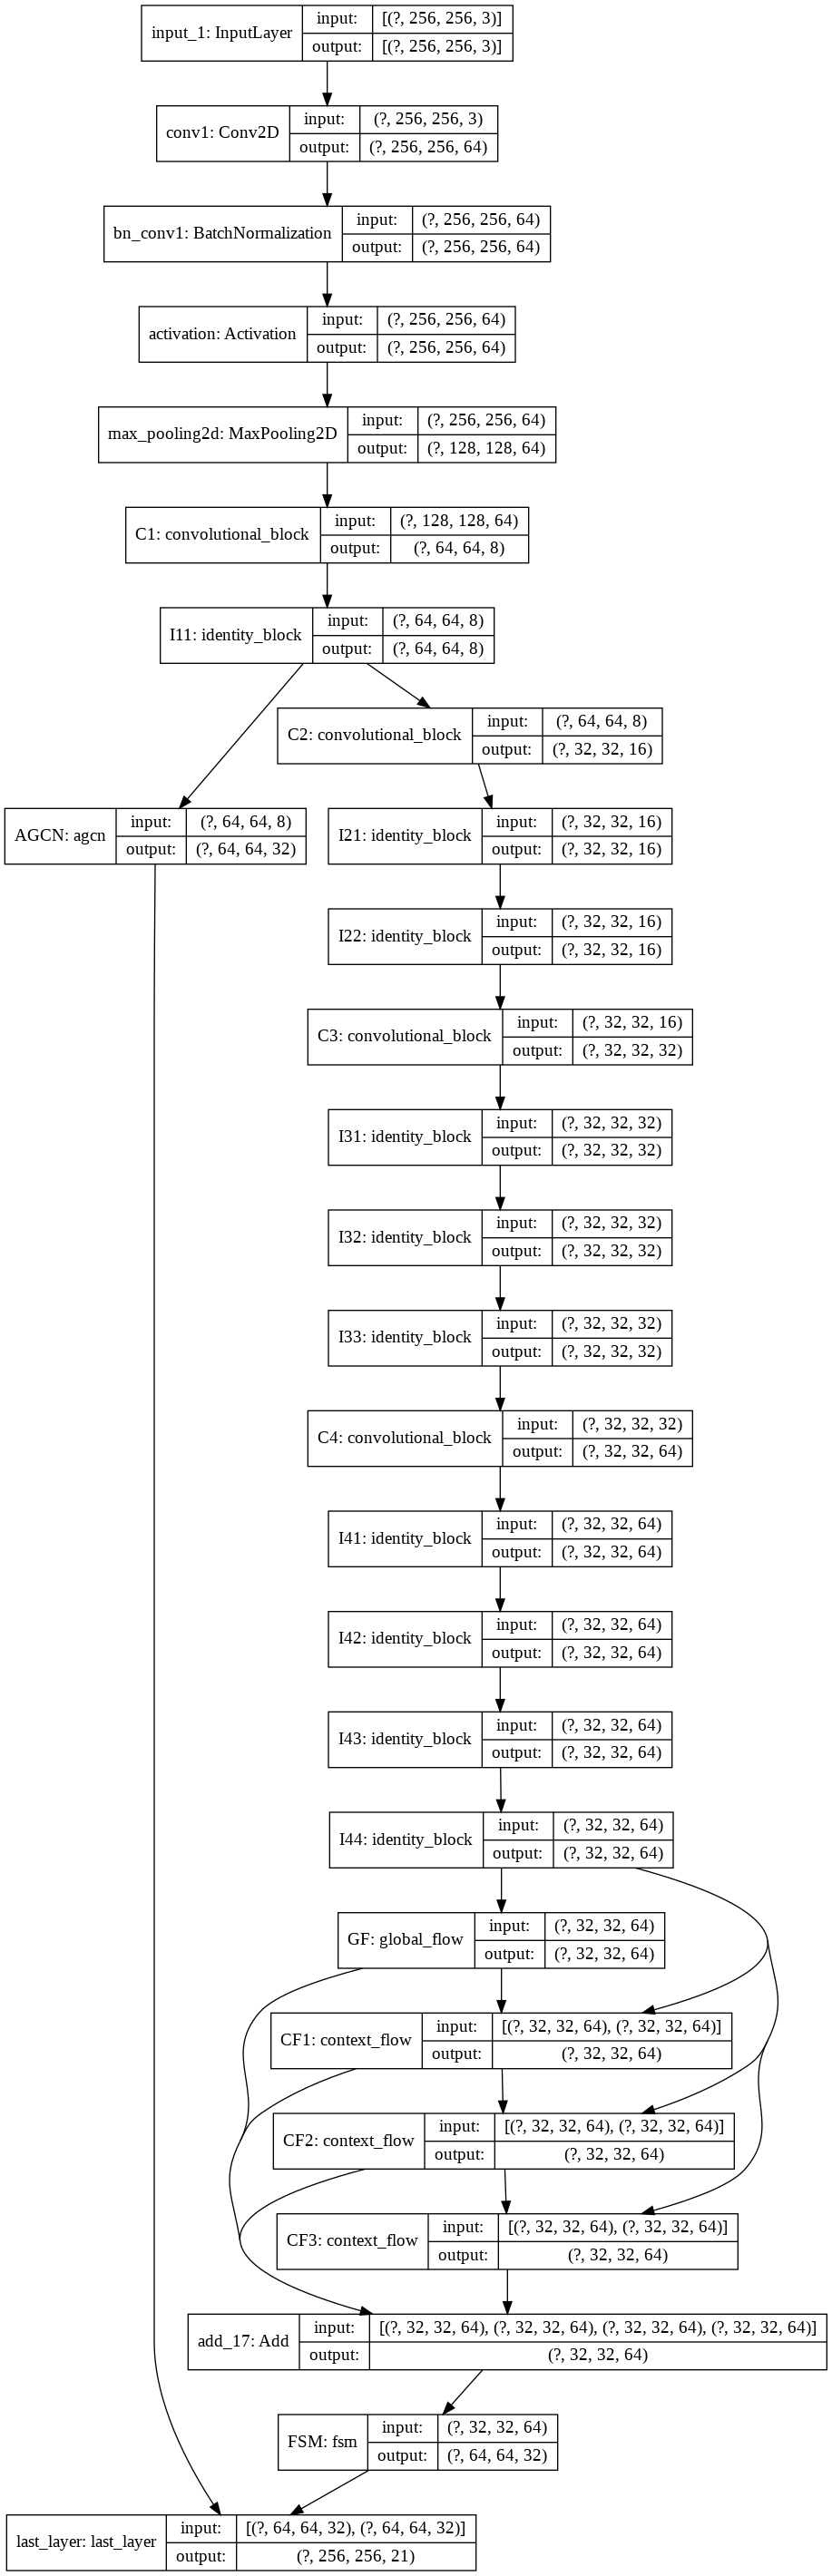

In [ ]:
tf.keras.utils.plot_model(
    model_canet, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

In [ ]:
X_train, X_test = train_test_split(file_names, test_size=0.1, random_state=34)

In [ ]:

class Dataset:
    # we will be modifying this CLASSES according to your data/problems
    CLASSES = ['road','drivable fallback','sidewalk','non-drivable fallback','person','animal','rider','motorcycle','autorickshaw',\
               'truck','curb','fence','billboard','pole','building''vegetation','sky','unlabeled','ego vehicle','ground','rectification border',\
               'train']

    # the parameters needs to changed based on your requirements
    # here we are collecting the file_names because in our dataset, both our images and maks will have same file name
    # ex: fil_name.jpg   file_name.mask.jpg
    def __init__(self, images_dir,mask_dir, file_names,classes):

        self.ids = file_names
        # the paths of images
        self.images_fps   = [os.path.join(images_dir, image_id+'_leftImg8bit.jpg') for image_id in self.ids]
        # the paths of segmentation images
        self.masks_fps    = [os.path.join(mask_dir, image_id+"_gtFine_polygons.png") for image_id in self.ids]
        # giving labels for each class
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.w=256
        self.h=256

    def __getitem__(self, i):

        # read data
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)

        image = cv2.resize(image,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)

        mask = cv2.resize(mask,(self.w,self.h),interpolation=cv2.INTER_AREA)
        image_mask = (mask[:,:])//10
        image_masks = [(image_mask == v) for v in self.class_values]
        #print(self.class_values)
        #print(image_masks)
        image_mask = np.stack(image_masks, axis=-1).astype('float')

        #print(image_mask.shape)

        a = np.random.uniform()
        if a<0.2:
            image = aug2.augment_image(image)
            image_mask = aug2.augment_image(image_mask)
        elif a<0.4:
            image = aug6.augment_image(image)
            image_mask = aug6.augment_image(image_mask)
        elif a<0.6:
            image = aug4.augment_image(image)
            image_mask = aug4.augment_image(image_mask)
        elif a<0.8:
            image = aug5.augment_image(image)
            image_mask = image_mask
        else:
            image = aug3.augment_image(image)
            image_mask = image_mask

        #p#rint(image_mask.shape)
        #print(image.shape)
        return image, image_mask

    def __len__(self):
        return len(self.ids)


class Dataloder(tf.keras.utils.Sequence):
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):

        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])

        batch = [np.stack(samples, axis=0) for samples in zip(*data)]

        return tuple(batch)

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# https://github.com/qubvel/segmentation_models
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from segmentation_models import Unet
tf.keras.backend.set_image_data_format('channels_last')

optim = tf.keras.optimizers.Adam(0.0001)

#focal_loss = sm.losses.cce_dice_loss

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss
total_loss = sm.losses.cce_dice_loss
model_canet.compile(optim, total_loss, metrics=[iou_score])

In [ ]:
# Dataset for train images

CLASSES = ['road','drivable fallback','sidewalk','non-drivable fallback','person','animal','rider','motorcycle','autorickshaw',\
                'truck','curb','fence','billboard','pole','building''vegetation','sky','unlabeled','ego vehicle','ground','rectification border',\
                'train']

img_path='data/images/'
mask_path='data/output/'

train_dataset = Dataset(img_path,mask_path,X_train, classes=CLASSES)
test_dataset  = Dataset(img_path,mask_path,X_test, classes=CLASSES)


train_dataloader = Dataloder(train_dataset, batch_size=4, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size=2, shuffle=True)
print(test_dataloader[0][0].shape)

R=tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_iou_score', factor=0.1, patience=3, verbose=0, mode='max',min_delta=0.00001)

ES=tf.keras.callbacks.EarlyStopping(
    monitor='val_iou_score', patience=5,mode='max',restore_best_weights=True)

(2, 256, 256, 3)


In [ ]:
history2 = model_canet.fit(train_dataloader,batch_size=4, epochs=10,
                            validation_data=test_dataloader,callbacks=[R,ES])

Epoch 1/10
901/901 [==============================] - 328s 364ms/step - loss: 0.9482 - iou_score: 0.1121 - val_loss: 0.9232 - val_iou_score: 0.1271 - lr: 1.0000e-04
Epoch 2/10
901/901 [==============================] - 326s 362ms/step - loss: 0.8987 - iou_score: 0.1402 - val_loss: 0.9088 - val_iou_score: 0.1417 - lr: 1.0000e-04
Epoch 3/10
901/901 [==============================] - 328s 364ms/step - loss: 0.8843 - iou_score: 0.1501 - val_loss: 0.8902 - val_iou_score: 0.1526 - lr: 1.0000e-04
Epoch 4/10
901/901 [==============================] - 328s 364ms/step - loss: 0.8687 - iou_score: 0.1577 - val_loss: 0.8654 - val_iou_score: 0.1531 - lr: 1.0000e-04
Epoch 5/10
901/901 [==============================] - 329s 365ms/step - loss: 0.8421 - iou_score: 0.1664 - val_loss: 0.8473 - val_iou_score: 0.1663 - lr: 1.0000e-04
Epoch 6/10
901/901 [==============================] - 330s 366ms/step - loss: 0.8318 - iou_score: 0.1736 - val_loss: 0.8451 - val_iou_score: 0.1675 - lr: 1.0000e-04
Epoch 7/10

In [ ]:
history3 = model_canet.fit(train_dataloader,batch_size=4, epochs=10,
                            validation_data=test_dataloader,callbacks=[R,ES])

Epoch 1/10
901/901 [==============================] - 333s 370ms/step - loss: 0.6090 - iou_score: 0.3876 - val_loss: 0.6264 - val_iou_score: 0.3777 - lr: 1.0000e-04
Epoch 2/10
901/901 [==============================] - 330s 366ms/step - loss: 0.6067 - iou_score: 0.3891 - val_loss: 0.6246 - val_iou_score: 0.3783 - lr: 1.0000e-04
Epoch 3/10
901/901 [==============================] - 331s 367ms/step - loss: 0.6020 - iou_score: 0.3914 - val_loss: 0.6219 - val_iou_score: 0.3820 - lr: 1.0000e-04
Epoch 4/10
901/901 [==============================] - 330s 366ms/step - loss: 0.6003 - iou_score: 0.3933 - val_loss: 0.6240 - val_iou_score: 0.3835 - lr: 1.0000e-04
Epoch 5/10
901/901 [==============================] - 326s 362ms/step - loss: 0.5980 - iou_score: 0.3937 - val_loss: 0.6137 - val_iou_score: 0.3871 - lr: 1.0000e-04
Epoch 6/10
901/901 [==============================] - 326s 362ms/step - loss: 0.5895 - iou_score: 0.4009 - val_loss: 0.6076 - val_iou_score: 0.3908 - lr: 1.0000e-04
Epoch 7/10

In [ ]:
history4 = model_canet.fit(train_dataloader,batch_size=4, epochs=5,
                            validation_data=test_dataloader,callbacks=[R,ES])

Epoch 1/5
901/901 [==============================] - 364s 404ms/step - loss: 0.5750 - iou_score: 0.4117 - val_loss: 0.6078 - val_iou_score: 0.3949 - lr: 1.0000e-04
Epoch 2/5
901/901 [==============================] - 325s 361ms/step - loss: 0.5756 - iou_score: 0.4107 - val_loss: 0.6034 - val_iou_score: 0.3962 - lr: 1.0000e-04
Epoch 3/5
901/901 [==============================] - 325s 360ms/step - loss: 0.5707 - iou_score: 0.4143 - val_loss: 0.5937 - val_iou_score: 0.4020 - lr: 1.0000e-04
Epoch 4/5
901/901 [==============================] - 327s 363ms/step - loss: 0.5678 - iou_score: 0.4166 - val_loss: 0.5957 - val_iou_score: 0.4039 - lr: 1.0000e-04
Epoch 5/5
901/901 [==============================] - 329s 365ms/step - loss: 0.5651 - iou_score: 0.4189 - val_loss: 0.5964 - val_iou_score: 0.4022 - lr: 1.0000e-04


- Appending all the distinct models trained above

In [ ]:
history2.history['iou_score'].extend(history3.history['iou_score'])
history2.history['iou_score'].extend(history4.history['iou_score'])

history2.history['val_iou_score'].extend(history3.history['val_iou_score'])
history2.history['val_iou_score'].extend(history4.history['val_iou_score'])

history2.history['loss'].extend(history3.history['loss'])
history2.history['loss'].extend(history4.history['loss'])

history2.history['val_loss'].extend(history3.history['val_loss'])
history2.history['val_loss'].extend(history4.history['val_loss'])

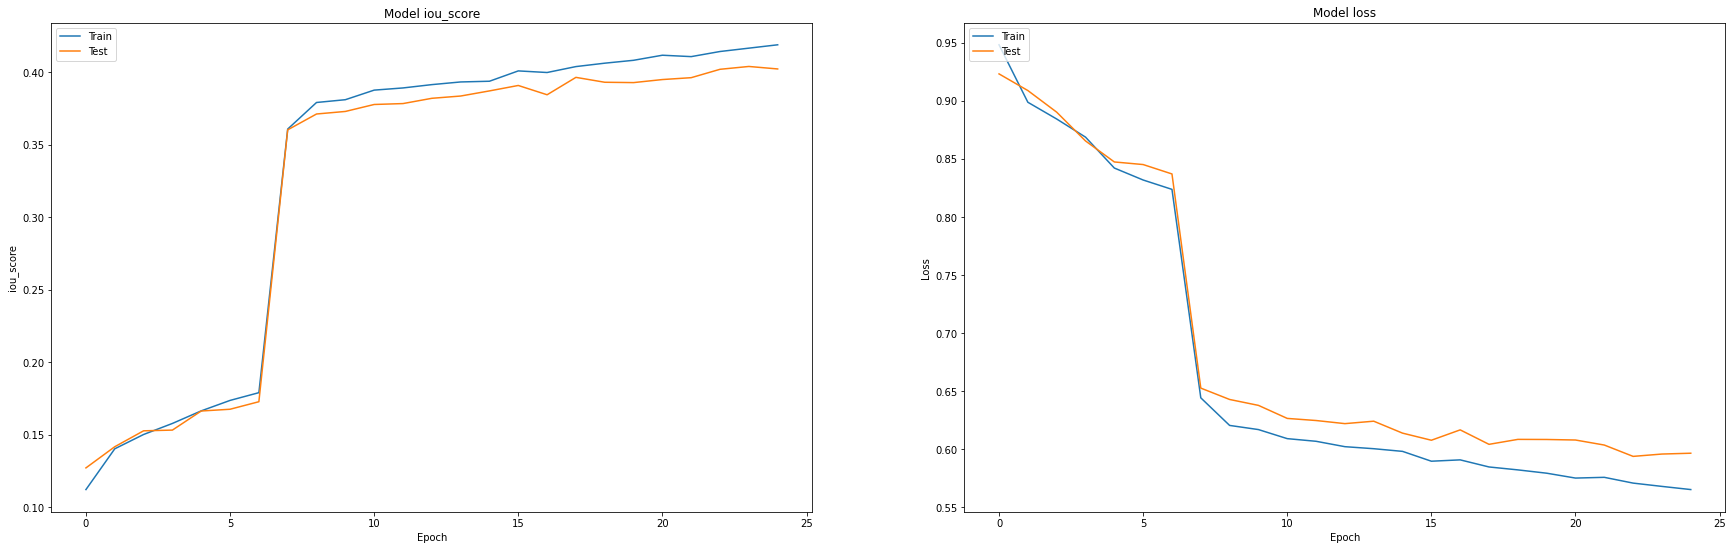

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 9))
plt.subplot(121)
plt.plot(history2.history['iou_score'])
plt.plot(history2.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

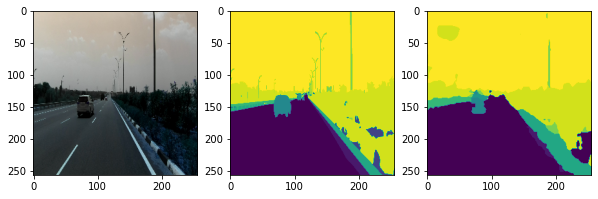

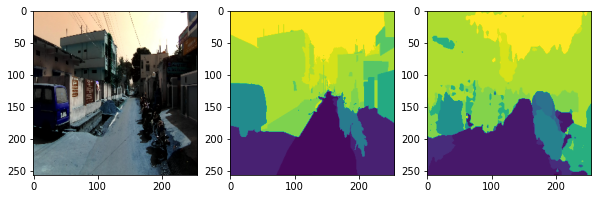

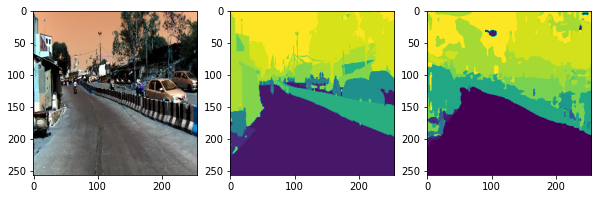

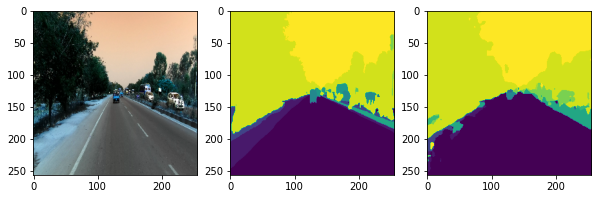

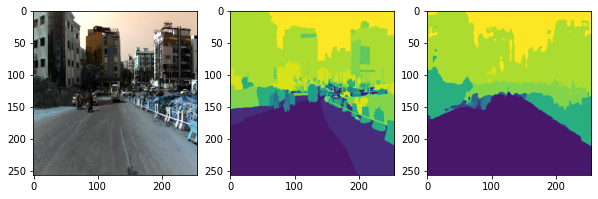

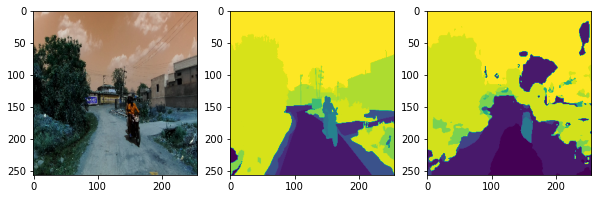

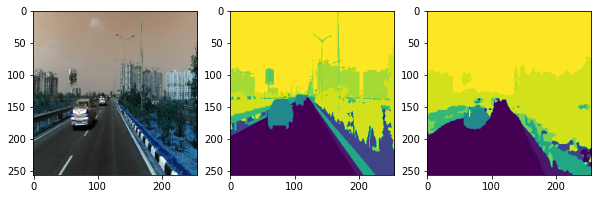

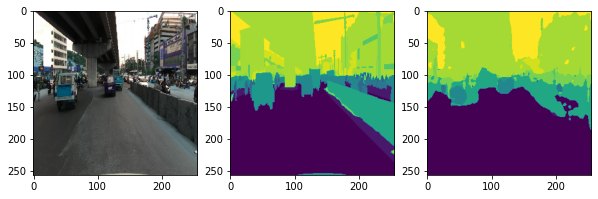

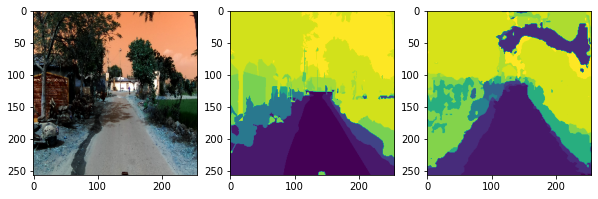

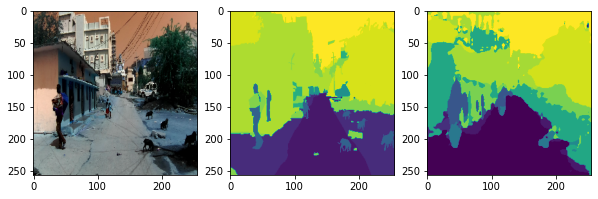

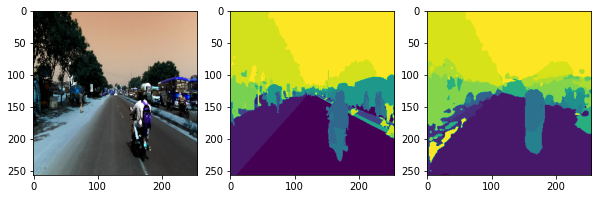

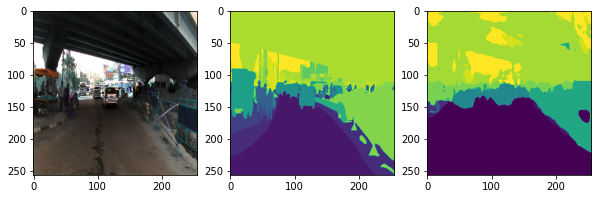

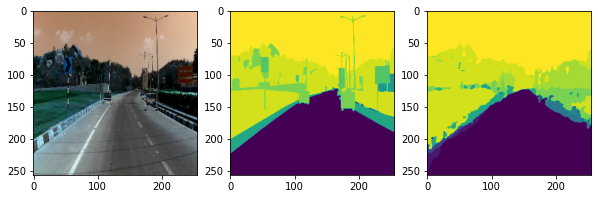

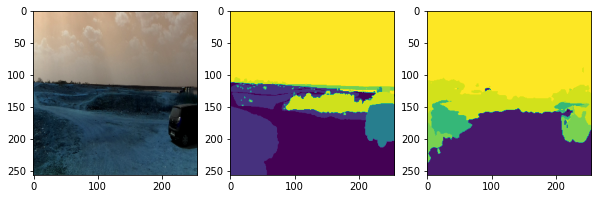

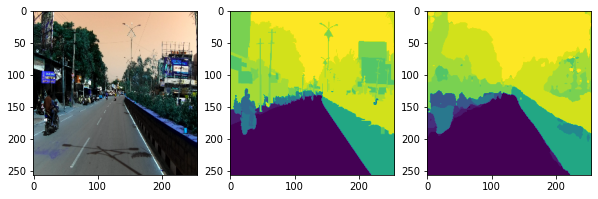

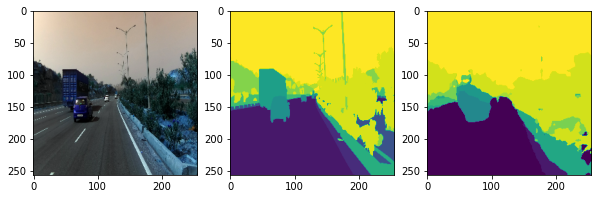

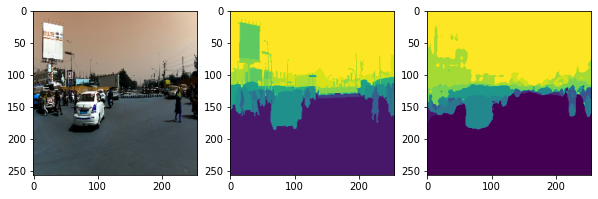

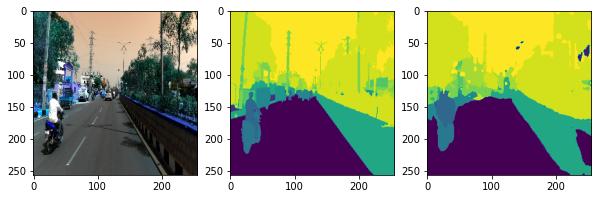

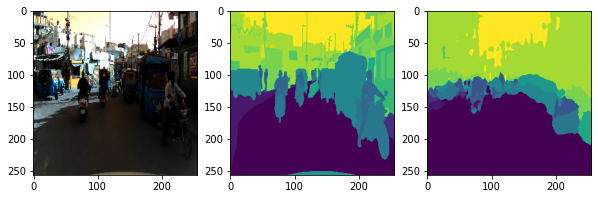

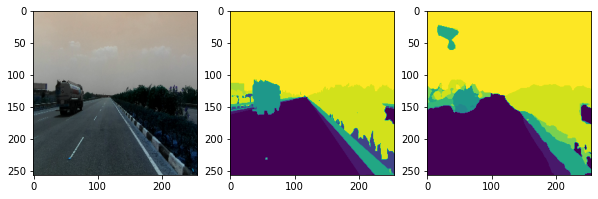

In [ ]:

for p, i in enumerate(X_test[0:20]):
    #original image
    image = cv2.imread(os.path.join(img_path, i+'_leftImg8bit.jpg'), cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (256,256))

    #predicted segmentation map
    predicted  = model_canet.predict(image[np.newaxis,:,:,:])
    predicted = tf.argmax(predicted,axis=-1)

    #original segmentation map
    image_mask = cv2.imread(os.path.join(mask_path, i+'_gtFine_polygons.png'), cv2.IMREAD_UNCHANGED)
    image_mask = cv2.resize(image_mask, (256,256))


    plt.figure(figsize=(10,6))
    plt.subplot(131)
    plt.imshow(image)
    plt.subplot(132)
    plt.imshow(image_mask)#, cmap='gray')
    plt.subplot(133)
    plt.imshow(predicted[0])#, cmap='gray')
    plt.show()

###Observations:

- Unet model achieved a validation iou score of 0.6100
- Canet model achieved a validation iou score of 0.4039